<a href="https://colab.research.google.com/github/Ivalomat/4-elements/blob/revisions/4UNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdFingerprintGenerator
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

In [ ]:
df = pd.read_csv("waaC_results.csv")
df.head()

,ID,Processed SMILES,Affinity
0,MCULE-9571960302,Cc1ccc(C)c(N2CCN(C(=O)c3ccc4c(=O)nc5c(-c6cccc(...,-11.7
1,MCULE-7096989023,Cc1ccc(C)c(N2CCN(C(=O)c3ccc4c(=O)nc5c(-c6ccc(F...,-11.5
2,MCULE-6669547482,COc1ccc2c(c1)OCCNC(=O)[C@@H](NC(=O)c1cnc3ccccn...,-11.0
3,MCULE-8565685776,O=C(c1ccccc1F)N1CCN(c2nc(C3CCCCC3)nc3c2cnn3-c2...,-10.8
4,MCULE-5308659577,Cc1cc(C(=O)N2CCC3(CCc4c3nc(-c3ccccc3)[nH]c4=O)...,-10.8


<Axes: >

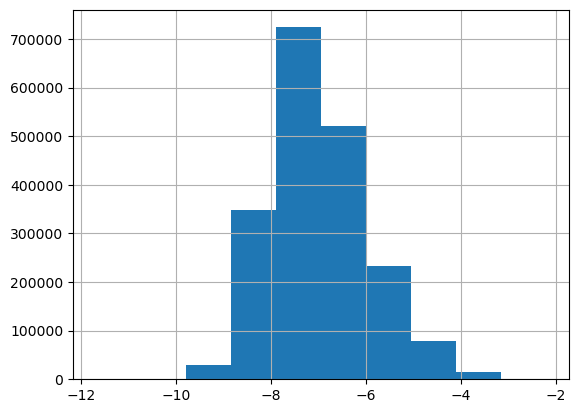

In [ ]:
df["Affinity"].hist()

In [ ]:
df.columns = ["ID", "Processed SMILES", "SCORE.INTER"]

df.head()

,ID,Processed SMILES,SCORE.INTER
0,MCULE-9571960302,Cc1ccc(C)c(N2CCN(C(=O)c3ccc4c(=O)nc5c(-c6cccc(...,-11.7
1,MCULE-7096989023,Cc1ccc(C)c(N2CCN(C(=O)c3ccc4c(=O)nc5c(-c6ccc(F...,-11.5
2,MCULE-6669547482,COc1ccc2c(c1)OCCNC(=O)[C@@H](NC(=O)c1cnc3ccccn...,-11.0
3,MCULE-8565685776,O=C(c1ccccc1F)N1CCN(c2nc(C3CCCCC3)nc3c2cnn3-c2...,-10.8
4,MCULE-5308659577,Cc1cc(C(=O)N2CCC3(CCc4c3nc(-c3ccccc3)[nH]c4=O)...,-10.8


In [ ]:
df.shape

(1953285, 3)

In [ ]:
class ActiveDocking:
    def __init__(self, dataframe,
                 id_col="ID", smiles_col="Processed SMILES", score_col="SCORE.INTER",
                 fingerprint_method="morgan", fingerprint_params=None,
                 model=None, eval_metrics=None,
                 top_ranked=1000, step=1000,
                 smiles_preprocessor=None):

        self.df = dataframe.copy()
        self.id_col = id_col
        self.smiles_col = smiles_col
        self.score_col = score_col
        self.top_ranked = top_ranked
        self.step = step
        self.smiles_preprocessor = smiles_preprocessor or (lambda x: x)

        self.fingerprint_method = fingerprint_method
        self.fingerprint_params = fingerprint_params or {}
        self.fpgen = self._init_fpgen()

        from sklearn.ensemble import RandomForestRegressor
        self.model = model or RandomForestRegressor(n_estimators=100, n_jobs=-1)

        self.eval_metrics = eval_metrics or {
            "RMSE": lambda y, y_pred: mean_squared_error(y, y_pred, squared=False),
            "R2": r2_score
        }

        self.fingerprints = None
        self.global_best = set()

    def _init_fpgen(self):
        method = self.fingerprint_method.lower()
        if method == "morgan":
            return rdFingerprintGenerator.GetMorganGenerator(
                radius=self.fingerprint_params.get("radius", 2),
                fpSize=self.fingerprint_params.get("fpSize", 1024)
            )
        elif method == "maccs":
            return lambda mol: np.array(MACCSkeys.GenMACCSKeys(mol).ToBitString(), dtype=int)
        else:
            raise ValueError(f"Unsupported fingerprint method: {method}")

    def compute_fingerprints(self):
        tqdm.pandas(desc="Generating fingerprints")
        smiles_list = self.df[self.smiles_col].progress_apply(self.smiles_preprocessor)
        mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

        if callable(self.fpgen):
            self.fingerprints = pd.DataFrame([self.fpgen(mol) for mol in mols])
        else:
            self.fingerprints = pd.DataFrame([
                self.fpgen.GetFingerprintAsNumPy(mol) for mol in mols
            ])

    def run(self, n_runs=10, train_size=10000):
        self.compute_fingerprints()
        self.global_best = set(self.df.sort_values([self.score_col, self.id_col]).iloc[:self.top_ranked][self.id_col])
        final_stats = []

        for run in tqdm(range(n_runs), desc="Running active docking"):
            docked, remaining = train_test_split(self.df, train_size=train_size)
            stats_df = self._active_learning_loop(docked, remaining)
            stats_df["RUN"] = run
            final_stats.append(stats_df)

        return pd.concat(final_stats).reset_index(drop=True)

    def _evaluate(self, y_true, y_pred):
        return {name: func(y_true, y_pred) for name, func in self.eval_metrics.items()}

    def _active_learning_loop(self, docked, remaining):
        stats = []
        fps = self.fingerprints
        full_data = pd.concat([docked, remaining]).reset_index(drop=True)
        docked = full_data.iloc[:docked.shape[0]].copy()
        remaining = full_data.iloc[docked.shape[0]:].copy()

        local_best = set(docked.sort_values([self.score_col, self.id_col]).iloc[:self.top_ranked][self.id_col])
        recall = len(local_best.intersection(self.global_best)) / self.top_ranked
        stats.append({"DOCKED": docked.shape[0], "SIMILARITY": 0, "RECALL": recall})

        while remaining.shape[0] > 0:
            train, test = train_test_split(docked, train_size=0.75)

            self.model.fit(fps.loc[train.index], train[self.score_col])

            test_eval = self._evaluate(test[self.score_col], self.model.predict(fps.loc[test.index]))
            ext_eval = self._evaluate(remaining[self.score_col], self.model.predict(fps.loc[remaining.index]))

            remaining["SCORE.PRED"] = self.model.predict(fps.loc[remaining.index])
            remaining = remaining.sort_values(["SCORE.PRED", self.id_col])
            docked = pd.concat([docked, remaining.iloc[:self.step]])
            remaining = remaining.iloc[self.step:]

            new_local_best = set(docked.sort_values([self.score_col, self.id_col]).iloc[:self.top_ranked][self.id_col])
            sim = len(new_local_best.intersection(local_best)) / len(new_local_best.union(local_best))
            local_best = new_local_best

            recall = len(docked[self.id_col].intersection(self.global_best)) / self.top_ranked
            result = {"DOCKED": docked.shape[0], "SIMILARITY": sim, "RECALL": recall}
            result.update({f"TEST_{k}": v for k, v in test_eval.items()})
            result.update({f"EXT_{k}": v for k, v in ext_eval.items()})
            stats.append(result)

            if sim > 0.95:
                break

        return pd.DataFrame(stats)

In [ ]:
df = pd.read_csv("waaC_results.csv")
df.columns = ["ID", "Processed SMILES", "SCORE.INTER"]
df.head()

In [ ]:
dock = ActiveDocking(
    dataframe=df,
    fingerprint_method="morgan",
    fingerprint_params={"radius": 2, "fpSize": 1024},
    top_ranked=1000,
    step=10000
)

final_stats = dock.run(n_runs=10, train_size=10000)
final_stats["GEN"] = 1

In [ ]:
final_stats.to_csv("../waaC_results_10000.csv", sep=",", index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = sns.color_palette("colorblind")  # Paleta con 5 colores

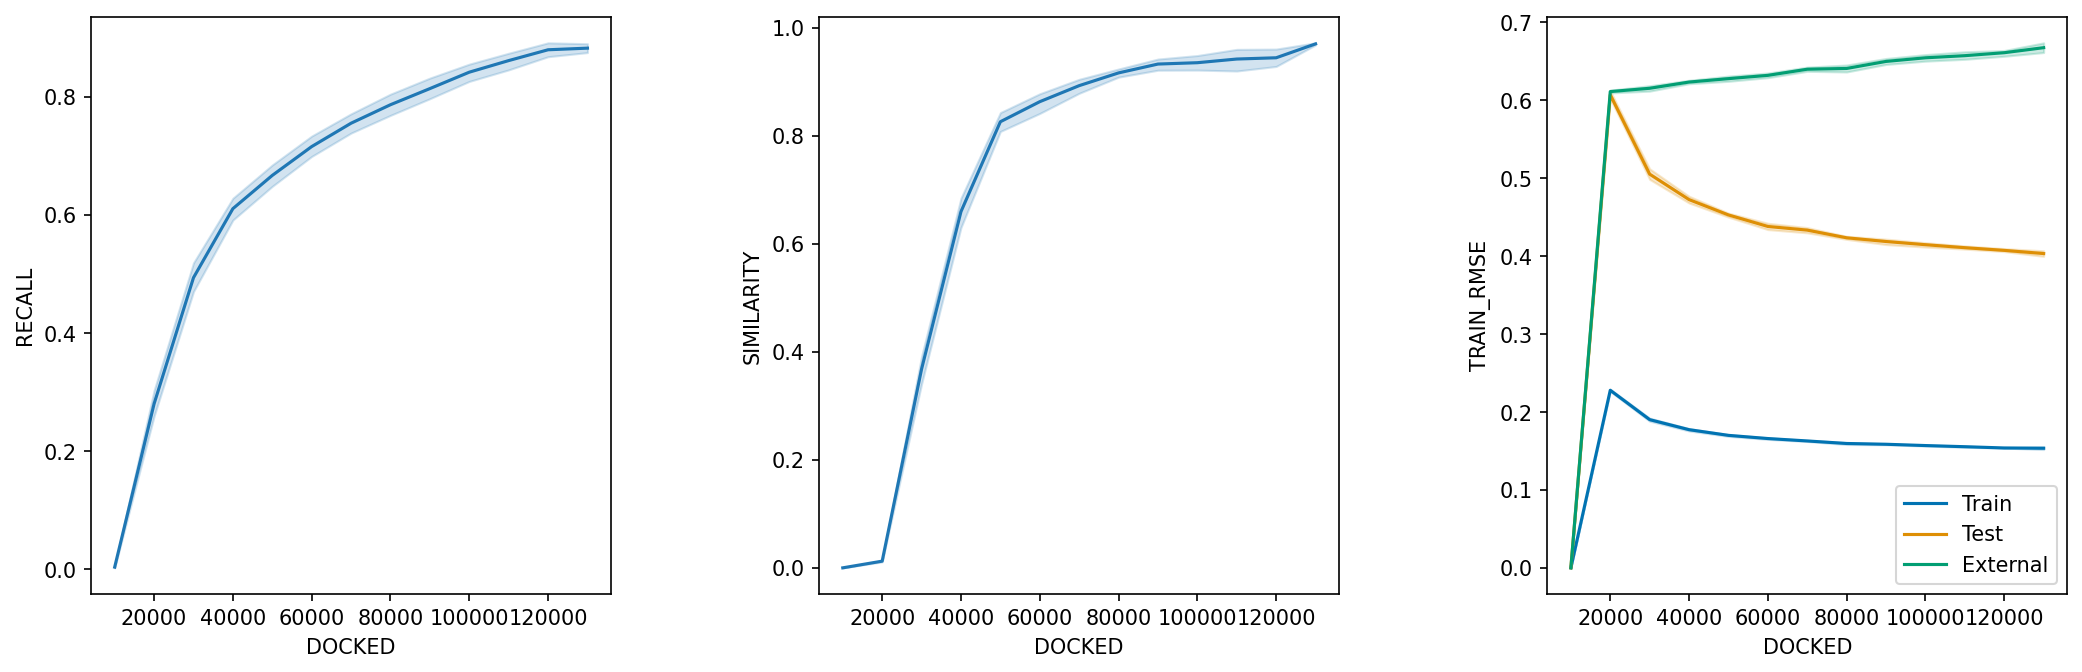

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=150, figsize=(17,5))
plt.subplots_adjust(wspace=0.4)

sns.lineplot(x="DOCKED", y="RECALL", data=final_stats, ax=ax1)
# ax1.set_title("1K")

sns.lineplot(x="DOCKED", y="SIMILARITY", data=final_stats, ax=ax2)
# ax2.set_title("5K")

sns.lineplot(x="DOCKED", y="TRAIN_RMSE", data=final_stats, color=custom_palette[0], ax=ax3, label="Train")
sns.lineplot(x="DOCKED", y="TEST_RMSE", data=final_stats, color=custom_palette[1],  ax=ax3, label="Test")
sns.lineplot(x="DOCKED", y="EXT_RMSE", data=final_stats, color=custom_palette[2],  ax=ax3, label="External")
ax3.legend()
# ax3.set_title("10K")
plt.show()